# Homework 2: Imbalanced Classification (SLT 7B)
Acot, Gacal, Ginez

**Deadline:** October 20, 11:59PM.

**Instructions:**
In this homework, you will be given a flexibility to choose a dataset you want to work on. For reference, you may use the answers of the cohort in the earlier exercise, see [link](https://docs.google.com/presentation/d/1uXrwW7yz4VBLxoZMbwtdtU2sf0z-OeK0FyB5EHU4L5Q/edit?usp=sharing).

The sections below are provided as guide on how you can structure your work to meet the minimum requirements for this homework, which are:
1. Brief description of the data: objective, data dictionary, minimal EDA relevant to the objective.
2. `automl` results using default hyperparameters of `sklearn` classifiers, use an appropriate metric beginning at this step. Include a brief (1-2 sentences) discussion of the chosen metric.
3. A confusion matrix for the chosen classifier from the above step, include a brief discussion of the matrix.
4. Perform 3 resampling techniques (excluding, Random Oversampling and Random Undersampling)
    * SMOTE (required)
    * ADASYN (required)
    * A technique not discussed in class
*Note: You may use the* `imblearn` *implementations instead of the function provided during the lecture*

5. Re-run our `automl` (default model hyperparameters) using the resampled training data. Comment on the differences.

6. *Optional:* You may choose to tune your resampling parameters (e.g. $\beta$, $K$) and show sensitivity plots for additional $Angas^{TM}$ points.


**Some Flexibilities you can take advantage of:**
* `StratifiedKFold` number of folds
* The classifiers you wish to use (minimum of 3)
* Size of the dataset

In [1]:
import pandas as pd
import time
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,  
                              GradientBoostingClassifier)
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

from imblearn.under_sampling import TomekLinks 
from imblearn.over_sampling import ADASYN, SMOTE

import warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")

In [2]:
# resammple automl
def resample_automl(X_trainval, y_trainval):
    res = {}
    skf = StratifiedKFold(n_splits=5)


    for model_name, model in models_dict.items():
        model_start = time.time()
        train_scores = []
        val_scores = []
        test_scores = []
        for train_index, val_index in skf.split(X_trainval, y_trainval):
            X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
            y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]
            
            
            model.fit(X_train, y_train)
            
            train_pred = model.predict(X_train)
            val_pred = model.predict(X_val)
            hold_pred = model.predict(X_holdout)
            
            train_score = f1_score(y_train, train_pred)
            val_score = f1_score(y_val, val_pred)
            hold_score = f1_score(y_holdout, hold_pred)

            train_scores.append(train_score)
            val_scores.append(val_score)
            test_scores.append(hold_score)
        model_end = time.time() - model_start
        res[model_name] = {
            'ave_train_f1':np.mean(train_scores) * 100,
            'ave_val_f1':np.mean(val_scores) * 100,
            'ave_test_f1': np.mean(test_scores) * 100,
            'runtime': model_end
        }

        print(f'{model_name}: done')
    
    res_df = pd.DataFrame(res).T
    
    return res_df['ave_test_f1'], res_df


## Brief Description of the Dataset Used

### Dataset and Dictionary

The dataset is extracted from the 1994 US Census database which has 14 features and 48,842 rows made available from UCI’s ML repo. 
The task is to predict whether a person will have a salary grade greater than 50K USD annually, or less than equal that. The features of the dataset are shown in the table below

<table>
    <tr><td><b>Feature</b></td><td><b>Values</b></td></tr>
    <tr><td>age</td><td>17-90 yrs old</td></tr>
    <tr><td>workclass</td><td>Private, Local-gov, self-emp-inc, etc.</td></tr>
    <tr><td>fnlwgt</td><td>Ex. 89814</td></tr>
    <tr><td>education</td><td>Pre-school, HS-grad, Masters, Doctorate, etc.</td></tr>
    <tr><td>marital-status</td><td>Never-married, *married, widowed, divorced, separated, etc.</td></tr>
    <tr><td>occupation</td><td>Farming-Fishing, exec-managerial, tech-support, etc.</td></tr>
    <tr><td>relationship</td><td>Own-child, Husband, Unmarried, Wife, etc.</td></tr>
    <tr><td>race</td><td>Black, White, Asian-Pac-Islander, etc.</td></tr>
    <tr><td>sex</td><td>Male, Female</td></tr>
    <tr><td>capital-gain</td><td>Ex. 7688</td></tr>
    <tr><td>capital-loss</td><td>Ex. 7688</td></tr>
    <tr><td>hours-per-week</td><td>Ex. 40</td></tr>
    <tr><td>native-country</td><td>United-States, Philippines, Mexico, etc.</td></tr>
</table>

The features are self-explanatory except `capital-gain`, `capital-loss`, `hours-per-week`, and `fnlwgt`. Capital-gain or loss is the income of the individual from external sources outside his salary such as income from investmets. Hours-per-week is the number of work hours per week. And finally, `fnlwgt`  is the number of people the census believes the entry represents.

<table>
    <tr><td><b>Target Variable</b></td><td><b>Values</b></td></tr>
    <tr><td>class</td><td><=50K, >50K</td></tr>
</table>

The table above shows the target variable and the values it contains. Again, fairly self-explanatory.

In [3]:
import os
os.path.abspath('C:\\Users\\JG\\jupyter directory\\datasets\\adult.csv')

'C:\\Users\\JG\\jupyter directory\\datasets\\adult.csv'

In [4]:
df = pd.read_csv('C:\\Users\\JG\\jupyter directory\\datasets\\adult.csv')

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


## EDA 

In [5]:
# preprocessing
df = df.applymap(lambda x: x.strip() if type(x) == str else x).applymap(lambda x: np.nan if x=='?' else x)
df = df.dropna(subset=['workclass', 'occupation', 'native-country'], axis=0)
df = df.drop(['education'], axis=1)
dummies = pd.concat([pd.get_dummies(df['workclass']), 
                     pd.get_dummies(df['marital-status']),
                     pd.get_dummies(df['occupation']),
                     pd.get_dummies(df['relationship']),
                     pd.get_dummies(df['race']),
                     pd.get_dummies(df['native-country'])], axis=1)
df = pd.concat([df, dummies], axis=1).drop(['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'native-country'], axis=1)
df['target'] = df['class'].apply(lambda x: 0 if x=='<=50K' else 1)
df = df.drop(['class'], axis=1)
df['sex'] = df['sex'].apply(lambda x: 1 if x=='Male' else 0)
df.head()

,age,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,Federal-gov,Local-gov,Private,...,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia,target
0,25,226802,7,1,0,0,40,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,38,89814,9,1,0,0,50,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,28,336951,12,1,0,0,40,0,1,0,...,0,0,0,0,0,0,1,0,0,1
3,44,160323,10,1,7688,0,40,0,0,1,...,0,0,0,0,0,0,1,0,0,1
5,34,198693,6,1,0,0,30,0,0,1,...,0,0,0,0,0,0,1,0,0,0


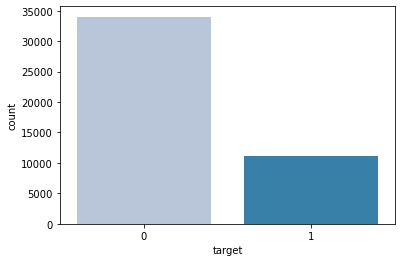

In [6]:
ax = sns.countplot(x='target', data=df, palette='PuBu');

<b>Target Array Composition</b>

The data is unbalanced since 75% of the target array are `0`s and only 25% are `1`s.

In [7]:
print(df['target'].value_counts(normalize=True))

0    0.752156
1    0.247844
Name: target, dtype: float64


### PCC

The Proportional Chance Criterion (PCC) allows us to set a baseline for the performance of my classifiers. It is ideal that the classifier models exceed this PCC in order for it to be deemed useful. A rule of thumb is to have a goal of 1.25*PCC for model accuracy.

<center>
<br>
    ${P}_{CC} = 
    (\frac{\large n_1}{\large N})^2+ (\frac{\large n_2}{\large N})^2 + \cdots + (\frac{\large n_M}{\large N})^2$

In [8]:
pcc = df['target'].value_counts(normalize=True)**2
print('1.25*PCC =', np.sum(pcc)*1.25*100)

1.25*PCC = 78.39566589795592


The dataset is significantly imbalanced as seen in the bar plot where the majority are the people with equal or less 50,000 income and the minority are the people with greater than 50,000 income.

## `automl` Default runs

In [9]:
X = df.drop('target', axis=1)
y = df['target']
feature_names = X.columns

In [10]:
# insert code here
from sklearn.model_selection import train_test_split, StratifiedKFold
(X_trainval, X_test, y_trainval, y_test) = train_test_split(X, y, 
                                           random_state=11, test_size=0.25, 
                                           stratify=y)

## Chosen Metric : F1 Score

<b>Why F1 score?</b>

The F-score, commonly known as the F1-score, is a model's accuracy on a dataset. It is used to assess binary classification algorithms that categorize examples as 'positive' or 'negative.' [[source]](https://medium.com/analytics-vidhya/accuracy-vs-f1-score-6258237beca2)
<br>The F1-score is a method of combining the model's precision and recall; it is defined as the harmonic mean of the model's precision and recall.
<br>The F1-score is frequently used to evaluate information retrieval systems such as search engines, as well as many different types of machine learning models.
<br>F1- Score was utilized to achieve an equal balance of accuracy and recall.

In [11]:
import time

models_dict = {
    'LogisticRegressor': LogisticRegression(random_state=11, max_iter=1_000_000),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'RandomForestClassifier': RandomForestClassifier(random_state=11),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=11)   
}


skf = StratifiedKFold(n_splits=5)

def automl(X, y, resampler=None):
# insert code here
    res = {}
    for model_name, model in models_dict.items():
        model_start = time.time()
        train_scores = []
        val_scores = []
        for train_index, val_index in skf.split(X, y):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]
            
            if resampler:
                (X_train, y_train) = resampler.fit_resample(X_train, y_train)
        

            model.fit(X_train, y_train)

            y_pred_train = model.predict(X_train)

            train_score = f1_score(y_train, y_pred_train)
            

            y_pred_val = model.predict(X_val)
            val_score = f1_score(y_val, y_pred_val)

            train_scores.append(train_score)
            val_scores.append(val_score)

    

        model_end = time.time() - model_start
        res[model_name] = {
            'ave_train_f1':np.mean(train_scores) * 100,
            'ave_val_f1':np.mean(val_scores) * 100,
            'runtime': model_end
        }

        print(f'{model_name}: done')
    df = pd.DataFrame(res).T
    return df


In [12]:
automl(X_trainval, y_trainval)

LogisticRegressor: done
KNeighborsClassifier: done
RandomForestClassifier: done
GradientBoostingClassifier: done


,ave_train_f1,ave_val_f1,runtime
LogisticRegressor,38.750893,38.785491,1.499988
KNeighborsClassifier,56.841616,40.758603,82.789016
RandomForestClassifier,99.982154,67.927802,19.467028
GradientBoostingClassifier,69.397957,68.672316,24.765437


Random Forest Classifier and Decision Tree Classifier evidently are overfitting with almost 100% train accuracy while having 80-85% validation accuracy. KNN and Logistic Regression, on the other hand, simply have below 80% validation accuracy. Gradient Boosting Classifier has a relatively good train and validation accuracy. However, this can still be improved.

## Confusion Matrix

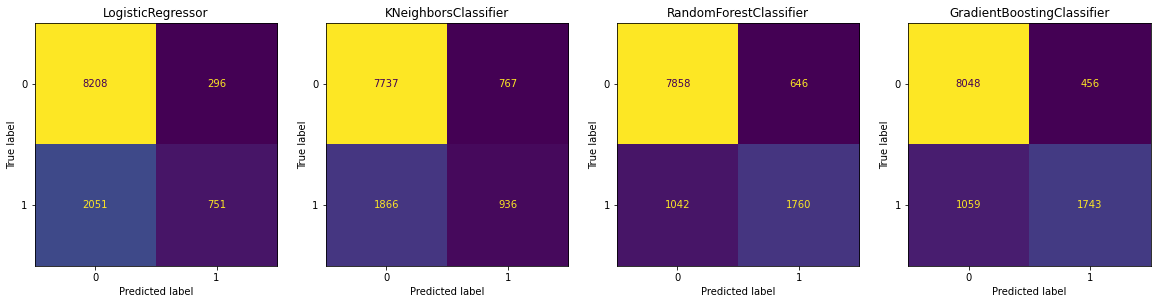

In [13]:
# insert code here
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

i = 0
for model_name, model in models_dict.items():
    
    model.fit(X_trainval, y_trainval)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i], colorbar=False)
    axes[i].set_title(model_name, fontsize=12)

    i += 1


The GBM Classifier model was able to <b>produce an F1-score of 69.69% of the holdout data set</b>. But this is without hypertuning and resampling the imbalanced data.


## Resampling

In resampling the imbalanced dataset, we used SMOTE, ADASYN, and TomekLinks.

In [14]:
sm = SMOTE(sampling_strategy=1.0, random_state=11)

In [15]:
ada = ADASYN(sampling_strategy=1.0, random_state=11)

In [16]:
tl = TomekLinks()

## Resampled data `automl` results

<b>SMOTE</b>

In [17]:
automl(X_trainval, y_trainval, sm)

LogisticRegressor: done
KNeighborsClassifier: done
RandomForestClassifier: done
GradientBoostingClassifier: done


,ave_train_f1,ave_val_f1,runtime
LogisticRegressor,57.074809,43.381526,7.024899
KNeighborsClassifier,82.279335,43.827775,170.199424
RandomForestClassifier,99.993630,68.604832,35.009451
GradientBoostingClassifier,89.293502,70.198231,43.663017


<b>ADASYN</b>

In [18]:
automl(X_trainval, y_trainval, ada)

LogisticRegressor: done
KNeighborsClassifier: done
RandomForestClassifier: done
GradientBoostingClassifier: done


,ave_train_f1,ave_val_f1,runtime
LogisticRegressor,60.656647,44.672481,21.660969
KNeighborsClassifier,80.694193,44.207173,182.849902
RandomForestClassifier,99.994058,68.105557,49.980330
GradientBoostingClassifier,89.069995,69.876212,61.435303


<b>TomekLinks</b>

In [19]:
automl(X_trainval, y_trainval, tl)

LogisticRegressor: done
KNeighborsClassifier: done
RandomForestClassifier: done
GradientBoostingClassifier: done


,ave_train_f1,ave_val_f1,runtime
LogisticRegressor,43.246628,41.809101,47.660677
KNeighborsClassifier,61.961226,42.292090,116.192554
RandomForestClassifier,99.980667,68.853009,60.865894
GradientBoostingClassifier,72.972191,70.440647,70.628640


Correctly predicting our dataset's minority improved by using various resampling methods on training and validation set. But in the test set the changes on the F1-scores are minimal, with only 2% increase in F1-score for GBM Classifer using TomekLinks. 

Initially, we hypothesized that the F1-score will improve after resampling. However, it is not the case for our dataset.

## Comparison of test scores

In [20]:
def resamp(X, y, resampler):
    X_new, y_new = resampler.fit_resample(X,y)
    return X_new, y_new

resamplers = [None, sm, ada, tl]
dict_ = {}
for model_name, model in models_dict.items():
    score_list = []
    for r in resamplers:
        if r:
            X_new, y_new = resamp(X_trainval, y_trainval, r)
        else:
            X_new, y_new = X_trainval, y_trainval
        model.fit(X_new, y_new)
        
        test_score = f1_score(y_test, model.predict(X_test))
        score_list.append(test_score)
        
    dict_[model_name] = score_list
    
df_test = pd.DataFrame(dict_, index=resamplers)


<AxesSubplot:>

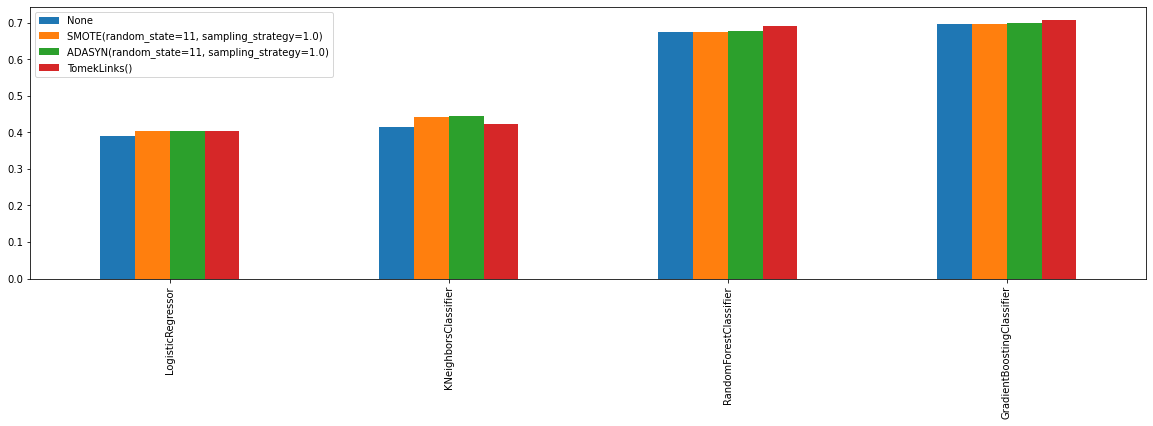

In [22]:
fig, ax = plt.subplots(figsize=(20,5))
df_test.T.plot(kind='bar', ax=ax)

In [23]:
df_test.T

,NaN,"SMOTE(random_state=11, sampling_strategy=1.0)","ADASYN(random_state=11, sampling_strategy=1.0)",TomekLinks()
LogisticRegressor,0.390231,0.404505,0.403842,0.403319
KNeighborsClassifier,0.415538,0.443322,0.445627,0.423472
RandomForestClassifier,0.675883,0.674699,0.677478,0.690676
GradientBoostingClassifier,0.697061,0.696316,0.700390,0.708238


## Sensitivity (Don't Mind this Prof Mike) 

**(SLT7B also dont mind this section, mali pa ito should be on train-val lang not on test set according to prof mike)**

We focused on GBM, since it has the highest F1-score among the models after resampling. Although any model can be used for sensitivity.


### GBM - SMOTE

**Beta**

In [47]:
def sensi_beta(X, y, resampler=None):
# insert code here
    res = {}
    model = GradientBoostingClassifier(random_state=11)   
    model_start = time.time()
    val_scores = []
    i = 0
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        if resampler:
            (X_train, y_train) = resampler.fit_resample(X_train, y_train)


        model.fit(X_train, y_train)



        y_pred_val = model.predict(X_val)
        val_score = f1_score(y_val, y_pred_val)

        val_scores.append(val_score)

        i += 1

    model_end = time.time() - model_start
    
    
    res['GBM'] = {
        f'{i}':np.mean(val_scores) * 100,
    }

   
    df = pd.DataFrame(res).T
    return df


In [60]:
beta_list = np.arange(0.4, 1.1, 0.1)

df_sm_b = pd.DataFrame()
for b in beta_list:
    sm = SMOTE(sampling_strategy=b, random_state=11)
    df_sm_b = df_sm_b.append(sensi_beta(X_trainval, y_trainval, sm))
    print(b)
df_sm_b.index = beta_list
df_sm_b.columns = ['f1_score_gbm']
df_sm_b.T

0.4
0.5
0.6
0.7
0.7999999999999999
0.8999999999999999
0.9999999999999999


,0.4,0.5,0.6,0.7,0.8,0.9,1.0
f1_score_gbm,69.639849,69.984268,69.982577,70.123068,69.932985,70.110685,69.958062


**K-Neighbors**

In [59]:
df_sm_k = pd.DataFrame()
k_list = range(2,100,8)
for k in k_list:
    sm = SMOTE(sampling_strategy=1.0, random_state=11, k_neighbors=k)
    df_sm_k = df_sm_k.append(sensi_beta(X_trainval, y_trainval, sm))
    print(k)
# df_sm_k.columns = list(k_list)
df_sm_k.index = k_list
df_sm_k.columns = ['f1_score_gbm']
df_sm_k.T

2
10
18
26
34
42
50
58
66
74
82
90
98


,2,10,18,26,34,42,50,58,66,74,82,90,98
f1_score_gbm,69.907982,69.988265,69.841814,69.987967,69.941518,69.764669,70.026615,69.832182,69.675251,69.886085,69.757828,69.742525,69.626363


### GBM - Adasyn

**Beta**

In [61]:
model = GradientBoostingClassifier(random_state=11)
beta_list = np.arange(0.5, 1.0, 0.1)

df_ada_b = pd.DataFrame()
for b in beta_list:
    ada = ADASYN(sampling_strategy=b, random_state=11)
    df_ada_b = df_ada_b.append(sensi_beta(X_trainval, y_trainval, ada))
    print(b)
df_ada_b.index = beta_list
df_ada_b.columns = ['f1_score_gbm']
df_ada_b.T

0.5
0.6
0.7
0.7999999999999999
0.8999999999999999


,0.5,0.6,0.7,0.8,0.9
f1_score_gbm,70.070017,70.170642,69.924921,70.057919,70.1318


**K-Neighbors**

In [62]:
k_list = range(2,30,2)
df_ada_k = pd.DataFrame()
k_list = range(2,100,8)
for k in k_list:
    ada = ADASYN(sampling_strategy=1.0, random_state=11, n_neighbors=k)
    df_ada_k = df_ada_k.append(sensi_beta(X_trainval, y_trainval, ada))
    print(k)

df_ada_k.index = k_list
df_ada_k.columns = ['f1_score_gbm']
df_ada_k.T

2
10
18
26
34
42
50
58
66
74
82
90
98


,2,10,18,26,34,42,50,58,66,74,82,90,98
f1_score_gbm,69.918842,69.869452,69.887073,69.85671,69.697132,69.901389,69.964925,69.82526,69.745633,69.752541,69.740515,69.852133,69.844051


As observed in the sensitivity tests with focus on GBM, the F1-scores and the run times have no apparent changes as the beta and k-Neighbors were varied.

In [63]:
import optuna

In [ ]:
def tune_GBM(X, y):
    from optuna.samplers import RandomSampler
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.model_selection import cross_validate
    
    def optimize(trial):
        # Definition of space search
        n_estimators = trial.suggest_int('n_estimators', 10,800, step=10)
        max_depth = trial.suggest_int('max_depth', 2,7)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-1)
        
        # Classifier definition
        model = GradientBoostingClassifier(n_estimators=n_estimators,
                                           max_depth=max_depth,
                                           max_features=max_features,
                                           learning_rate=learning_rate)

    
        cr_val = cross_validate(model, X, y, cv=skf, scoring=['accuracy'], return_train_score=False)
        return np.mean(cr_val['test_accuracy'])
    
    study = optuna.create_study(direction='maximize')
    study.optimize(optimize, n_trials=50, n_jobs=4)
    return study, optimize

In [64]:
skf

StratifiedKFold(n_splits=5, random_state=None, shuffle=False)